<a href="https://colab.research.google.com/github/WaliBandawu/Chaotic-Greywolf-Dragonfly-Algorithm-for-feature-selection-on-Stroke-datasets/blob/main/Final_Work_CDWA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm import tqdm
import time
# from CGWODA.py import HybridOptimizationAlgorithm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import preprocessing
# from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.neighbors import KNeighborsClassifier
# from zoofs import DragonFlyOptimization

# from zoofs import GreyWolfOptimization
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
# from zoofs.baseoptimizationalgorithm import BaseOptimizationAlgorithm
# from zoofs import DragonFlyOptimization

In [ ]:
%cd CGWODA

/content/drive/MyDrive/Colab Notebooks/CGWODA


In [ ]:
from sklearn.metrics import log_loss
def objective_function_topass( model, X_train, y_train, X_test, y_test):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the classification error rate
    error_rate = 1 - accuracy
    cardinality_R = X_train.shape[1]
    # Calculate the total number of features in C
    total_features_C = 10
    alpha = 0.99
    # Calculate beta
    beta = 1 - alpha
    # Calculate the fitness value
    fitness = error_rate * alpha + beta * (cardinality_R / total_features_C)
    return fitness


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def run_da_optimization(num_iterations, X_train, y_train, X_test, y_test):
    da_results_per_iteration = []
    da_best_feature_lists = []
    da_best_dims = []
    da_best_scores = []

    for _ in tqdm(range(num_iterations), desc="Iterations", unit="iteration"):
        # Replace with your actual algorithm import and instantiation
        algo_object = DragonFlyOptimization(objective_function_topass,
                                            n_iteration=100,
                                            population_size=11,
                                            minimize=True,
                                            logger=None,

                                           method='random')

        model = KNeighborsClassifier()

        algo_object.fit(model, X_train, y_train, X_test, y_test, verbose=False)

        da_iteration_results = {
            "results_per_iteration": algo_object.best_results_per_iteration,
            "best_dim_list": algo_object.best_dim.tolist(),
            "best_feature_list": algo_object.best_feature_list,
            "best_score": algo_object.best_score
        }
        da_best_feature_list = algo_object.best_feature_list
        da_best_dim = algo_object.best_dim
        da_best_score = algo_object.best_score

        da_results_per_iteration.append(da_iteration_results)
        da_best_feature_lists.append(da_best_feature_list)
        da_best_dims.append(da_best_dim.tolist())
        da_best_scores.append(da_best_score)

    return da_results_per_iteration, da_best_feature_lists, da_best_dims, da_best_scores



In [ ]:
def run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test):
    results_per_iteration = []
    best_feature_lists = []
    best_dims = []
    best_scores = []

    for _ in tqdm(range(num_iterations), desc="Iterations", unit="iteration"):
        hybrid_object = HybridOptimizationAlgorithm(
            objective_function=objective_function_topass,
            n_iteration=100,
            population_size=11,
            logger=None,
        )

        knn_classifier = KNeighborsClassifier()

        hybrid_object.fit(knn_classifier, X_train, y_train, X_test, y_test, verbose=False)


        iteration_results = {
            "results_per_iteration": hybrid_object.best_results_per_iteration,
            "best_dim_list": hybrid_object.best_dim.tolist(),
            "best_feature_list": hybrid_object.best_feature_list,
            "best_score": hybrid_object.best_score
        }

        best_feature_list = hybrid_object.best_feature_list
        best_dim = hybrid_object.best_dim
        best_score = hybrid_object.best_score

        results_per_iteration.append(iteration_results)
        best_feature_lists.append(best_feature_list)
        best_dims.append(best_dim.tolist())
        best_scores.append(best_score)

    return results_per_iteration, best_feature_lists, best_dims, best_scores

In [ ]:
def preprocess_dataset(dataset):
        # Separate the features and target variable
        if 'id' in dataset.columns:
            dataset = dataset.drop('id', axis=1)
        if 'bmi' in dataset.columns:
            dataset['bmi'].fillna(dataset['bmi'].mean(), inplace=True)
        if 'sex' in dataset.columns:
            sex_mode_val = dataset['sex'].mode().iloc[0]
            dataset['sex'].fillna(sex_mode_val,inplace=True)

        # Perform label encoding on categorical features
        categorical_features = dataset.select_dtypes(include=['object']).columns
        label_encoder = LabelEncoder()
        for feature in categorical_features:
            dataset[feature] = label_encoder.fit_transform(dataset[feature])



        # Normalize the data
        scaler = MinMaxScaler()
        normalized = scaler.fit_transform(dataset)

        # Return the preprocessed dataset
        preprocessed_dataset = pd.DataFrame(dataset, columns=dataset.columns)
        return preprocessed_dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd 'drive/My Drive/Colab Notebooks'


/content/drive/My Drive/Colab Notebooks


In [ ]:
|

## DRAGONFLY ANS CGWO-DA

## Dataset 1(https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Classification of stroke patients using data miningwith AdaBoost, Decision Tree and Random Forest models

In [ ]:
stroke=pd.read_csv('stroke4.csv')
stroke=preprocess_dataset(stroke)
X = stroke.drop(['stroke'],axis=1)
y = stroke['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [23:17<00:00, 46.58s/iteration]


In [ ]:
features

[['age', 'work_type'],
 ['heart_disease', 'Residence_type'],
 ['ever_married', 'work_type'],
 ['gender', 'hypertension', 'ever_married', 'work_type'],
 ['gender', 'age'],
 ['gender', 'heart_disease'],
 ['gender', 'hypertension', 'heart_disease', 'smoking_status'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'ever_married', 'Residence_type'],
 ['age', 'ever_married', 'Residence_type'],
 ['gender', 'hypertension', 'heart_disease', 'smoking_status'],
 ['age', 'ever_married', 'Residence_type'],
 ['hypertension', 'heart_disease', 'ever_married'],
 ['gender', 'hypertension', 'heart_disease', 'smoking_status'],
 ['hypertension', 'ever_married', 'work_type'],
 ['heart_disease'],
 ['gender', 'hypertension', 'heart_disease', 'Residence_type'],
 ['hypertension', 'heart_disease', 'ever_married'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'ever_married', 'Residence_type'],
 ['hypertension', 'heart_disease'],
 ['age', 'ever_married'],
 ['age',
  'hype

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'hypertension',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_085819/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_085819/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   14.53 GB / 16.11 GB (90.2%)
Train Data Rows:    9722
Train Data Columns: 7
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.0842754
[2000]	valid_set's binary_error: 0.0647482
[3000]	valid_set's binary_error: 0.0596095


	0.9435	 = Validation score   (accuracy)
	24.95s	 = Training   runtime
	0.99s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.036999


	0.9681	 = Validation score   (accuracy)
	5.81s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9558	 = Validation score   (accuracy)
	8.14s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9568	 = Validation score   (accuracy)
	9.55s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: CatBoost ...
	0.9671	 = Validation score   (accuracy)
	24.67s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9424	 = Validation score   (accuracy)
	3.53s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9435	 = Validation score   (accuracy)
	2.83s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8736	 = Validation score   (accuracy)
	27.43s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: XGBoost ...
	0.9538	 = Validation score   (accuracy)
	4.13s	 = Training   runtime
	0.07

In [ ]:
cgwoda_dataset1=predictor_combined.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.974306       0.767453  44.179704                0.002513           1.316195            2       True         14
1              LightGBM   0.968140       0.220406   5.813602                0.220406           5.813602            1       True          4
2              CatBoost   0.967112       0.023121  24.667517                0.023121          24.667517            1       True          7
3         LightGBMLarge   0.967112       0.115362   3.192301                0.115362           3.192301            1       True         13
4      RandomForestEntr   0.956835       0.281702   9.550698                0.281702           9.550698            1       True          6
5      RandomForestGini   0.955807       0.277325   8.139713                0.277325           8.139713            1       True          5
6               XGBoost   0

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)


Iterations:   3%|▎         | 1/30 [01:12<34:52, 72.14s/iteration] [ 2023-08-21 11:27:32,841 ] 1 individuals went zero
 [ 2023-08-21 11:27:41,057 ] 1 individuals went zero
 [ 2023-08-21 11:27:41,281 ] 2 individuals went zero
Iterations:   7%|▋         | 2/30 [02:22<33:04, 70.87s/iteration] [ 2023-08-21 11:28:26,805 ] 1 individuals went zero
 [ 2023-08-21 11:28:52,640 ] 1 individuals went zero
Iterations:  10%|█         | 3/30 [03:31<31:35, 70.19s/iteration] [ 2023-08-21 11:29:17,312 ] 1 individuals went zero
 [ 2023-08-21 11:29:22,635 ] 1 individuals went zero
 [ 2023-08-21 11:29:26,358 ] 1 individuals went zero
 [ 2023-08-21 11:29:52,146 ] 1 individuals went zero
 [ 2023-08-21 11:29:55,970 ] 1 individuals went zero
 [ 2023-08-21 11:29:57,145 ] 1 individuals went zero
 [ 2023-08-21 11:29:59,969 ] 1 individuals went zero
 [ 2023-08-21 11:30:00,697 ] 1 individuals went zero
Iterations:  13%|█▎        | 4/30 [04:40<30:11, 69.66s/iteration] [ 2023-08-21 11:30:48,193 ] 1 individuals went zer

In [ ]:
da_features

[['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age', 'hypertension', 'ever_married'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age', 'hypertension', 'ever_married']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_090139/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_090139/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   14.28 GB / 16.11 GB (88.7%)
Train Data Rows:    9722
Train Data Columns: 3
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

In [ ]:
da_dataset1=predictor_combined.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.948613       0.441607  10.568441                0.006377           1.999578            2       True         14
1      RandomForestEntr   0.943474       0.150679   4.656412                0.150679           4.656412            1       True          6
2      RandomForestGini   0.943474       0.169379   3.863895                0.169379           3.863895            1       True          5
3        ExtraTreesEntr   0.943474       0.191874   1.257327                0.191874           1.257327            1       True          9
4        ExtraTreesGini   0.940391       0.131202   1.251241                0.131202           1.251241            1       True          8
5              CatBoost   0.938335       0.004634   4.657119                0.004634           4.657119            1       True          7
6        KNeighborsDist   0

## DataSet 2

COMPARATIVE ANALYSIS OF STROKE CLASSIFICATION USING THE K-NEAREST NEIGHBOR DECISION TREE, AND MULTILAYER PERCEPTRON METHODS

https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset

In [ ]:
stroke2 = pd.read_csv('stroke/stroke2.csv')

In [ ]:
stroke2=preprocess_dataset(stroke2)
X = stroke2.drop(['stroke'],axis=1)
y = stroke2['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [23:08<00:00, 46.27s/iteration]


In [ ]:
features

[['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['hypertension', 'Residence_type'],
 ['gender', 'Residence_type'],
 ['hypertension', 'ever_married', 'Residence_type', 'smoking_status'],
 ['hypertension', 'Residence_type', 'smoking_status'],
 ['gender', 'hypertension', 'ever_married'],
 ['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age'],
 ['age', 'ever_married'],
 ['gender', 'heart_disease', 'Residence_type'],
 ['age', 'work_type'],
 ['heart_disease', 'work_type'],
 ['gender'],
 ['gender', 'age'],
 ['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'heart_disease'],
 ['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender', 'ever_married', 'Residence_type'],
 ['gender', 'age'],
 ['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender', 'hypert

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi']])
Stroke_data['stroke']=y
predictor= TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset2= predictor.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_090240/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_090240/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   14.28 GB / 16.11 GB (88.7%)
Train Data Rows:    9466
Train Data Columns: 6
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.0960929
[2000]	valid_set's binary_error: 0.0802534


	0.9229	 = Validation score   (accuracy)
	6.05s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.0496304


	0.9546	 = Validation score   (accuracy)
	1.98s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9113	 = Validation score   (accuracy)
	2.6s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9155	 = Validation score   (accuracy)
	3.3s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	0.9493	 = Validation score   (accuracy)
	7.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9155	 = Validation score   (accuracy)
	2.86s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9124	 = Validation score   (accuracy)
	2.81s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8532	 = Validation score   (accuracy)
	15.73s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	0.9345	 = Validation score   (accuracy)
	1.75s	 = Training   runtime
	0.04s	 =

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   0.959873       0.073046   2.546255                0.073046           2.546255            1       True         13
1   WeightedEnsemble_L2   0.959873       0.080801   4.481066                0.007755           1.934811            2       True         14
2              LightGBM   0.954593       0.083547   1.983286                0.083547           1.983286            1       True          4
3              CatBoost   0.949314       0.007116   7.466172                0.007116           7.466172            1       True          7
4               XGBoost   0.934530       0.039949   1.745622                0.039949           1.745622            1       True         11
5            LightGBMXT   0.922914       0.377090   6.051013                0.377090           6.051013            1       True          3
6      RandomForestEntr   0

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)


NameError: ignored

In [ ]:
da_features

[['age', 'work_type'],
 ['age', 'work_type'],
 ['age'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age', 'work_type']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset2=predictor_combined.leaderboard()

## Dataset 3

In [ ]:
%cd ..

/content/drive/MyDrive/Colab Notebooks


In [ ]:
stroke3 = pd.read_csv('stroke/stroke3.csv')

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9249117

In [ ]:
stroke3=preprocess_dataset(stroke3)
X = stroke3.drop(['stroke'],axis=1)
y = stroke3['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [2:33:48<00:00, 307.63s/iteration]


In [ ]:
features

NameError: ignored

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset3=predictor_combined.leaderboard()

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [26:16:20<00:00, 3152.70s/iteration]


In [ ]:
da_features

[['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['gender', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['Residence_type', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi'],
 ['hypertension', 'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['hypertension', 'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset3=predictor.leaderboard()

## Dataset 4

In [ ]:
stroke4 = pd.read_csv('stroke/stroke10.csv')

https://ieeexplore.ieee.org/abstract/document/10235026

In [ ]:
stroke4=preprocess_dataset(stroke4)
X = stroke4.drop(['stroke'],axis=1)
y = stroke4['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [1:55:34<00:00, 231.14s/iteration]


In [ ]:
features

[['ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['sex', 'ever_married'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['hypertension', 'heart_disease', 'work_type', 'Residence_type'],
 ['work_type'],
 ['work_type', 'Residence_type', 'smoking_status'],
 ['Residence_type'],
 ['heart_disease'],
 ['Residence_type'],
 ['heart_disease', 'smoking_status'],
 ['avg_glucose_level', 'bmi'],
 ['work_type'],
 ['ever_married', 'Residence_type', 'smoking_status'],
 ['heart_disease', 'smoking_status'],
 ['sex', 'heart_disease', 'Residence_type'],
 ['sex', 'work_type', 'Residence_type', 'smoking_status'],
 ['hypertension'],
 ['avg_glucose_level', 'bmi'],
 ['heart_disease'],
 ['hypertension'],
 ['sex', 'heart_disease', 'Residence_type'],
 ['avg_glucose_level', 'bmi'],
 ['work_type', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'work_type', 'avg_glucose_level', 'bmi'],
 ['sex', 'ever_married', 'Residence_type'],
 ['heart_disease', 'work_type', 

In [ ]:
Stroke_data =pd.DataFrame(X[['avg_glucose_level', 'bmi']])
Stroke_data['stroke']=y

In [ ]:

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset4=predictor_combined.leaderboard()

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [2:44:59<00:00, 329.99s/iteration]


In [ ]:
da_features

[['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_l

In [ ]:
Stroke_data =pd.DataFrame(X[['avg_glucose_level', 'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset4=predictor_combined.leaderboard()

## Dataset 5

In [ ]:
stroke5 = pd.read_csv('stroke/stroke12.csv')

https://www.kaggle.com/code/bunyaminpolat/heart-stroke-prediction-with-lr-knn-svm#Implement-SVM-and-Evaluate

In [ ]:
stroke5=preprocess_dataset(stroke5)
X = stroke5.drop(['stroke'],axis=1)
y = stroke5['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [01:41<00:00,  3.38s/iteration]


In [ ]:
features

[['age', 'heart_disease', 'ever_married', 'Residence_type', 'smoking_status'],
 ['work_type', 'Residence_type'],
 ['gender',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'avg_glucose_level'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['hypertension', 'ever_married', 'Residence_type'],
 ['hypertension', 'heart_disease', 'ever_married'],
 ['hypertension', 'ever_married', 'Residence_type'],
 ['age', 'heart_disease', 'ever_married', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'ever_married', 'work_type', 'smoking_status'],
 ['gender',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level'],
 ['work_type', 'Residence_type'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'avg_glucose_level'],
 ['work_type', 'Residence_type'],
 ['hypertension', 'work_type'],
 ['gender',
  'hypertension',
  'heart_disease',
  'e

In [ ]:
Stroke_data =pd.DataFrame(X[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset5=predictor_combined.leaderboard()

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [01:58<00:00,  3.94s/iteration]


In [ ]:
da_features

[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi'],
 ['age', 'heart_disease', 'Re

In [ ]:
Stroke_data =pd.DataFrame(X[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset5 =predictor_combined.leaderboard()

## Dataset 6

In [ ]:
stroke6 = pd.read_csv('stroke/stroke 13.csv')

In [ ]:
X = stroke6.drop(['target'],axis=1)
y = stroke6['target']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [02:21<00:00,  4.72s/iteration]


In [ ]:
features

[['sex', 'cp', 'trestbps', 'chol', 'exang', 'slope', 'ca'],
 ['cp', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'exang', 'slope'],
 ['age', 'chol', 'fbs', 'restecg', 'exang', 'slope', 'thal'],
 ['age', 'sex', 'chol', 'fbs', 'restecg', 'slope', 'ca', 'thal'],
 ['age', 'chol', 'exang'],
 ['sex', 'cp', 'fbs', 'oldpeak', 'slope'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'slope', 'ca'],
 ['age', 'sex', 'cp', 'fbs', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['sex', 'cp', 'trestbps', 'chol'],
 ['sex', 'cp', 'trestbps', 'chol', 'exang', 'slope', 'ca'],
 ['sex', 'cp', 'trestbps', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'ca'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['age', 'sex', 'chol', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 'trestbps', 'chol', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 't

In [ ]:
Stroke_data =pd.DataFrame(X[['cp', 'oldpeak', 'slope', 'ca']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset6=predictor_combined.leaderboard()

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|███████████████████████████████████████████████████████████████| 30/30 [04:37<00:00,  9.25s/iteration]


In [ ]:
da_features

[['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'exang', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca'],
 ['cp', 'fbs', 'oldpeak', 'slope', 'ca'],
 ['cp', 'exang', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['sex', 'cp', 'trestbps', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['sex', 'cp', 'trestbps', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'restecg', 'oldpeak', 'slope', 'ca'],
 ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'fbs', 'restecg', 'oldpeak

In [ ]:
Stroke_data =pd.DataFrame(X[['cp', 'oldpeak', 'slope', 'ca']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset6=predictor_combined.leaderboard()

## Dataset 7

In [ ]:
%cd stroke/

/content/drive/MyDrive/Colab Notebooks/stroke


In [ ]:
stroke7 = pd.read_csv('stroke/stroke14.csv')[:1000]

In [ ]:
stroke7=preprocess_dataset(stroke7)
X = stroke7.drop(['Stroke'],axis=1)
y = stroke7['Stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
X.shape

(1868, 20)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [09:34<00:00, 19.15s/iteration]


In [ ]:
features

[['CholCheck', 'Smoke', 'MentHlth', 'DiffWalk'],
 ['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'AlcoholConsump',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['HighChol', 'Smoke', 'Fruits', 'Veggies', 'NoDocbcCost'],
 ['Diabetes_012',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk

In [ ]:
Stroke_data =pd.DataFrame(X[ ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset7=predictor_combined.leaderboard()

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [11:45<00:00, 23.51s/iteration]


In [ ]:
da_features

[['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'Veggies',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'BMI',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_012',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'PhysHlth',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Veggies',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'BMI',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'BMI',
  '

In [ ]:
Stroke_data =pd.DataFrame(X[ ['Diabetes_012',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset7=predictor_combined.leaderboard()

## Dataset 8

In [ ]:
stroke8 = pd.read_csv('stroke/stroke15.csv')

http://jurnal.unprimdn.ac.id/index.php/JUSIKOM/article/view/4083/2562

In [ ]:
stroke8=preprocess_dataset(stroke8)
X = stroke8.drop(['stroke'],axis=1)
y = stroke8['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
X.shape

(9466, 10)

In [ ]:
num_iterations = 30
results, features, dims, scores = run_cgwoda_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [20:21<00:00, 40.71s/iteration]


In [ ]:
features

[['hypertension', 'heart_disease', 'ever_married', 'Residence_type'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['heart_disease'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['hypertension', 'heart_disease', 'Residence_type'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['gender'],
 ['hypertension', 'ever_married', 'smoking_status'],
 ['age', 'work_type'],
 ['age'],
 ['hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type'],
 ['hypertension', 'Residence_type'],
 ['age'],
 ['gender', 'hypertension', 'work_type'],
 ['age', 'work_type'],
 ['age'],
 ['Residence_type', 'smoking_status'],
 ['age', 'hypertension', 'ever_married'],
 ['Residence_type', 'smoking_status'],
 ['Residence_type', 'smoking_status'],
 ['age', 'work_type'],
 ['age'],
 ['gender', 'work_type'],
 ['age',
  'hypert

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'hypertension',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
cgwoda_dataset8=predictor_combined.leaderboard()

In [ ]:
num_iterations = 30
da_results, da_features, da_dims, da_scores = run_da_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 30/30 [32:33<00:00, 65.11s/iteration]


In [ ]:
da_features

[['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age', 'heart_disease'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age','heart_disease']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
da_dataset8=predictor_combined.leaderboard()

## GreyWolf

In [ ]:
def run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test):
    results_per_iteration = []
    best_feature_lists = []
    best_dims = []
    best_scores = []

    for _ in tqdm(range(num_iterations), desc="Iterations", unit="iteration"):
        grey_object = GreyWolfOptimization(
            objective_function=objective_function_topass,
            n_iteration=100,
            population_size=11,
            logger=None,
            method=2
        )

        knn_classifier = KNeighborsClassifier()

        grey_object.fit(knn_classifier, X_train, y_train, X_test, y_test, verbose=False)


        iteration_results = {
            "results_per_iteration": grey_object.best_results_per_iteration,
            "best_dim_list": grey_object.best_dim.tolist(),
            "best_feature_list": grey_object.best_feature_list,
            "best_score": grey_object.best_score
        }

        best_feature_list = grey_object.best_feature_list
        best_dim = grey_object.best_dim
        best_score = grey_object.best_score

        results_per_iteration.append(iteration_results)
        best_feature_lists.append(best_feature_list)
        best_dims.append(best_dim.tolist())
        best_scores.append(best_score)

    return results_per_iteration, best_feature_lists, best_dims, best_scores

In [ ]:
num_iterations = 20
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 20/20 [20:20<00:00, 61.00s/iteration]


In [ ]:
features

[['age', 'ever_married', 'work_type'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['gender', 'age'],
 ['age', 'heart_disease', 'ever_married', 'work_type'],
 ['age', 'ever_married'],
 ['age', 'hypertension', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['age', 'hypertension', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'hypertension', 'heart_disease'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease', 'ever_married', 'work_type'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease', 'ever_married'],
 ['gender', 'age']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [10:09<00:00, 60.97s/iteration]


In [ ]:
features

[['age', 'hypertension'],
 ['age', 'work_type'],
 ['age', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'ever_married'],
 ['age', 'work_type'],
 ['age', 'hypertension', 'heart_disease', 'ever_married'],
 ['age', 'heart_disease', 'ever_married'],
 ['gender', 'age'],
 ['age', 'work_type'],
 ['age', 'hypertension', 'heart_disease', 'ever_married']]

In [ ]:
stroke=pd.read_csv('stroke4.csv')
stroke=preprocess_dataset(stroke)
X = stroke.drop(['stroke'],axis=1)
y = stroke['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
Stroke_data =pd.DataFrame(X[['age', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_090434/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_090434/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   14.02 GB / 16.11 GB (87.1%)
Train Data Rows:    9722
Train Data Columns: 5
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.0873587
[2000]	valid_set's binary_error: 0.0750257
[3000]	valid_set's binary_error: 0.0709147


	0.9322	 = Validation score   (accuracy)
	5.96s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: LightGBM ...
	0.963	 = Validation score   (accuracy)
	1.6s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9404	 = Validation score   (accuracy)
	5.5s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9424	 = Validation score   (accuracy)
	4.1s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: CatBoost ...
	0.9692	 = Validation score   (accuracy)
	17.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9342	 = Validation score   (accuracy)
	2.87s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9353	 = Validation score   (accuracy)
	2.94s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8684	 = Validation score   (accuracy)
	16.87s	 = Training   runtime
	0.03s	 

In [ ]:
greywolf_dataset1=predictor_combined.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost   0.969168       0.008498  17.465971                0.008498          17.465971            1       True          7
1   WeightedEnsemble_L2   0.969168       0.012943  19.581920                0.004446           2.115950            2       True         14
2              LightGBM   0.963001       0.046357   1.598413                0.046357           1.598413            1       True          4
3         LightGBMLarge   0.959918       0.019789   2.071293                0.019789           2.071293            1       True         13
4               XGBoost   0.945529       0.036170   1.753348                0.036170           1.753348            1       True         11
5      RandomForestEntr   0.942446       0.142508   4.103955                0.142508           4.103955            1       True          6
6      RandomForestGini   0

## Dataset2

In [ ]:
stroke2 = pd.read_csv('stroke/stroke2.csv')

In [ ]:
stroke2=preprocess_dataset(stroke2)
X = stroke2.drop(['stroke'],axis=1)
y = stroke2['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [09:52<00:00, 59.30s/iteration]


In [ ]:
features

[['age', 'heart_disease', 'ever_married'],
 ['age', 'work_type'],
 ['age', 'hypertension', 'heart_disease'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'hypertension', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['age'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [10:00<00:00, 60.00s/iteration]


In [ ]:
features

[['age', 'avg_glucose_level', 'bmi'],
 ['age'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['age', 'heart_disease', 'Residence_type'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension', 'heart_disease'],
 ['age', 'heart_disease', 'ever_married']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [09:51<00:00, 59.11s/iteration]


In [ ]:
features

[['age', 'heart_disease', 'ever_married'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['age', 'work_type'],
 ['age', 'hypertension', 'heart_disease'],
 ['age', 'work_type'],
 ['age', 'ever_married', 'work_type'],
 ['age', 'hypertension', 'heart_disease'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'ever_married', 'work_type']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age', 'ever_married', 'avg_glucose_level', 'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
greywolf_dataset2=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_090622/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_090622/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   13.89 GB / 16.11 GB (86.3%)
Train Data Rows:    9466
Train Data Columns: 4
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.139388
[2000]	valid_set's binary_error: 0.116156
[3000]	valid_set's binary_error: 0.10982
[4000]	valid_set's binary_error: 0.107709
[5000]	valid_set's binary_error: 0.101373
[6000]	valid_set's binary_error: 0.0992608
[7000]	valid_set's binary_error: 0.0982049
[8000]	valid_set's binary_error: 0.0918691
[9000]	valid_set's binary_error: 0.0887012
[10000]	valid_set's binary_error: 0.0834213


	0.9187	 = Validation score   (accuracy)
	14.0s	 = Training   runtime
	1.22s	 = Validation runtime
Fitting model: LightGBM ...
	0.9472	 = Validation score   (accuracy)
	1.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9229	 = Validation score   (accuracy)
	6.05s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.924	 = Validation score   (accuracy)
	6.67s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	0.9514	 = Validation score   (accuracy)
	21.66s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9197	 = Validation score   (accuracy)
	1.79s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9197	 = Validation score   (accuracy)
	1.54s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8131	 = Validation score   (accuracy)
	12.89s	 = Training   runtime
	0.03

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   0.952482       0.190155   5.119686                0.190155           5.119686            1       True         13
1   WeightedEnsemble_L2   0.952482       0.195608   7.285686                0.005453           2.166001            2       True         14
2              CatBoost   0.951426       0.009238  21.658020                0.009238          21.658020            1       True          7
3              LightGBM   0.947202       0.041257   1.539131                0.041257           1.539131            1       True          4
4               XGBoost   0.925026       0.060800   2.661443                0.060800           2.661443            1       True         11
5      RandomForestEntr   0.923970       0.119370   6.665715                0.119370           6.665715            1       True          6
6      RandomForestGini   0

## Dataset3

In [ ]:
stroke3 = pd.read_csv('stroke/stroke3.csv')

In [ ]:
stroke3=preprocess_dataset(stroke3)
X = stroke3.drop(['stroke'],axis=1)
y = stroke3['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [1:51:17<00:00, 667.74s/iteration]


In [ ]:
features

[['bmi'],
 ['hypertension', 'Residence_type', 'bmi'],
 ['hypertension', 'Residence_type', 'bmi'],
 ['heart_disease', 'Residence_type', 'bmi'],
 ['gender', 'hypertension', 'bmi'],
 ['Residence_type', 'bmi'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['ever_married', 'bmi'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [1:52:25<00:00, 674.52s/iteration]


In [ ]:
features

[['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['bmi'],
 ['gender', 'ever_married', 'bmi'],
 ['Residence_type', 'bmi'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'hypertension', 'bmi'],
 ['heart_disease', 'Residence_type', 'bmi'],
 ['gender', 'hypertension', 'bmi'],
 ['bmi'],
 ['ever_married', 'Residence_type', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [1:51:31<00:00, 669.15s/iteration]


In [ ]:
features

[['Residence_type', 'bmi'],
 ['heart_disease', 'Residence_type', 'bmi'],
 ['Residence_type', 'bmi'],
 ['heart_disease', 'Residence_type', 'bmi'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'hypertension', 'bmi'],
 ['ever_married', 'Residence_type', 'bmi'],
 ['gender', 'hypertension', 'bmi'],
 ['hypertension', 'Residence_type', 'bmi'],
 ['gender', 'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
greywolf_dataset3=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_090920/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_090920/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   13.46 GB / 16.11 GB (83.6%)
Train Data Rows:    85234
Train Data Columns: 6
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

[1000]	valid_set's binary_error: 0.1088
[2000]	valid_set's binary_error: 0.0784
[3000]	valid_set's binary_error: 0.068
[4000]	valid_set's binary_error: 0.0568
[5000]	valid_set's binary_error: 0.0524
[6000]	valid_set's binary_error: 0.0484
[7000]	valid_set's binary_error: 0.0468
[8000]	valid_set's binary_error: 0.046
[9000]	valid_set's binary_error: 0.0432
[10000]	valid_set's binary_error: 0.0408


	0.9592	 = Validation score   (accuracy)
	145.62s	 = Training   runtime
	6.28s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.0256
[2000]	valid_set's binary_error: 0.0216


	0.9784	 = Validation score   (accuracy)
	35.16s	 = Training   runtime
	1.18s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.976	 = Validation score   (accuracy)
	81.76s	 = Training   runtime
	0.58s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9752	 = Validation score   (accuracy)
	64.01s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: CatBoost ...
	0.9796	 = Validation score   (accuracy)
	143.91s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9712	 = Validation score   (accuracy)
	16.72s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9716	 = Validation score   (accuracy)
	19.44s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8604	 = Validation score   (accuracy)
	128.59s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost ...
	0.9704	 = Validation score   (accuracy)
	15.29s	 = Training   runtim

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9856       8.048999  407.047781                0.009389           3.058100            2       True         14
1              CatBoost     0.9796       0.028944  143.909738                0.028944         143.909738            1       True          7
2              LightGBM     0.9784       1.182194   35.164864                1.182194          35.164864            1       True          4
3         LightGBMLarge     0.9764       0.448699   11.730188                0.448699          11.730188            1       True         13
4      RandomForestGini     0.9760       0.577690   81.764579                0.577690          81.764579            1       True          5
5      RandomForestEntr     0.9752       0.387774   64.006055                0.387774          64.006055            1       True          6
6        ExtraTreesE

## Dataset4

In [ ]:
stroke4 = pd.read_csv('stroke/stroke10.csv')

In [ ]:
stroke4=preprocess_dataset(stroke4)
X = stroke4.drop(['stroke'],axis=1)
y = stroke4['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [51:16<00:00, 307.62s/iteration]


In [ ]:
features

[['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [49:09<00:00, 294.92s/iteration]


In [ ]:
features

[['work_type', 'avg_glucose_level', 'bmi'],
 ['work_type', 'avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [51:43<00:00, 310.38s/iteration]


In [ ]:
features

[['hypertension', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['work_type', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['avg_glucose_level', 'bmi']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
greywolf_dataset4=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_092536/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_092536/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.96 GB / 16.11 GB (74.2%)
Train Data Rows:    40920
Train Data Columns: 2
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

[1000]	valid_set's binary_error: 0.1872
[2000]	valid_set's binary_error: 0.1176
[3000]	valid_set's binary_error: 0.0976
[4000]	valid_set's binary_error: 0.0812
[5000]	valid_set's binary_error: 0.07
[6000]	valid_set's binary_error: 0.0628
[7000]	valid_set's binary_error: 0.058
[8000]	valid_set's binary_error: 0.0528
[9000]	valid_set's binary_error: 0.0444
[10000]	valid_set's binary_error: 0.0408


	0.9596	 = Validation score   (accuracy)
	27.67s	 = Training   runtime
	2.33s	 = Validation runtime
Fitting model: LightGBM ...
	0.9992	 = Validation score   (accuracy)
	2.59s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (accuracy)
	15.27s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (accuracy)
	9.98s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (accuracy)
	43.83s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (accuracy)
	6.03s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (accuracy)
	5.74s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.6676	 = Validation score   (accuracy)
	60.34s	 = Training   runtime
	0.06s	 = Validati

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost     1.0000       0.016037   43.830332                0.016037          43.830332            1       True          7
1        KNeighborsDist     1.0000       0.020126    0.034176                0.020126           0.034176            1       True          2
2   WeightedEnsemble_L2     1.0000       0.025358   46.912814                0.009321           3.082482            2       True         14
3        KNeighborsUnif     1.0000       0.033831    0.031796                0.033831           0.031796            1       True          1
4      RandomForestEntr     1.0000       0.262403    9.981746                0.262403           9.981746            1       True          6
5      RandomForestGini     1.0000       0.271477   15.266491                0.271477          15.266491            1       True          5
6        ExtraTreesE

## Dataset5

In [ ]:
stroke5 = pd.read_csv('stroke/stroke12.csv')

In [ ]:
stroke5=preprocess_dataset(stroke5)
X = stroke5.drop(['stroke'],axis=1)
y = stroke5['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 20
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)


Iterations: 100%|██████████| 20/20 [01:29<00:00,  4.47s/iteration]


In [ ]:
features

[['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender', 'age', 'heart_disease', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender', 'age', 'heart_disease', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender', 'age', 'heart_disease', 'bmi', 'smoking_status'],
 ['gender', 'age', 'heart_disease', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', '

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:43<00:00,  4.30s/iteration]


In [ ]:
features

[['gender', 'age', 'heart_disease', 'bmi', 'smoking_status'],
 ['age',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['gender', 'age', 'heart_disease', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['ever_married', 'work_type', 'bmi', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['age', 'heart_disease', 'Residence_type', 'smoking_status'],
 ['gender', 'age', 'heart_disease', 'bmi', 'smoking_status']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
greywolf_dataset5=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_093601/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_093601/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.81 GB / 16.11 GB (73.3%)
Train Data Rows:    322
Train Data Columns: 6
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:         

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost   0.892308       0.002084  0.433392                0.002084           0.433392            1       True          7
1   WeightedEnsemble_L2   0.892308       0.003529  1.769680                0.001445           1.336288            2       True         14
2         LightGBMLarge   0.876923       0.003101  0.423799                0.003101           0.423799            1       True         13
3               XGBoost   0.876923       0.006238  0.198725                0.006238           0.198725            1       True         11
4        NeuralNetTorch   0.861538       0.013143  1.675428                0.013143           1.675428            1       True         12
5       NeuralNetFastAI   0.861538       0.014190  0.804051                0.014190           0.804051            1       True         10
6              LightGBM   0.846154

## Dataset6

In [ ]:
stroke6 = pd.read_csv('stroke/stroke 13.csv')

In [ ]:
X = stroke6.drop(['target'],axis=1)
y = stroke6['target']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 20
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 20/20 [02:36<00:00,  7.82s/iteration]


In [ ]:
features

[['cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'fbs', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'fbs', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'fbs', 'restecg', 'slope', 'ca', 'thal'],
 ['cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['age', 's

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [01:11<00:00,  7.15s/iteration]


In [ ]:
features

[['age', 'sex', 'cp', 'fbs', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['fbs', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['cp', 'fbs', 'restecg', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age', 'sex', 'cp', 'fbs', 'restecg', 'oldpeak', 'slope', 'ca', 'thal']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
greywolf_dataset6=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_093612/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_093612/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.81 GB / 16.11 GB (73.3%)
Train Data Rows:    330
Train Data Columns: 9
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:         

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost   0.893939       0.002844  0.523227                0.002844           0.523227            1       True          7
1            LightGBMXT   0.893939       0.003334  0.328904                0.003334           0.328904            1       True          3
2   WeightedEnsemble_L2   0.893939       0.004204  1.115063                0.000870           0.786158            2       True         14
3       NeuralNetFastAI   0.893939       0.014028  0.811162                0.014028           0.811162            1       True         10
4         LightGBMLarge   0.863636       0.002306  0.324585                0.002306           0.324585            1       True         13
5              LightGBM   0.863636       0.003648  0.355035                0.003648           0.355035            1       True          4
6        NeuralNetTorch   0.863636

## Dataset7

In [ ]:
stroke7 = pd.read_csv('stroke/stroke14.csv')[:1000]

In [ ]:
stroke7=preprocess_dataset(stroke7)
X = stroke7.drop(['Stroke'],axis=1)
y = stroke7['Stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 20
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 20/20 [11:38<00:00, 34.94s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'PhysHlth',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'PhysHlth',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI'

In [ ]:
Stroke_data =pd.DataFrame(X[ ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
greywolf_dataset7=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_093624/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_093624/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.81 GB / 16.11 GB (73.3%)
Train Data Rows:    1868
Train Data Columns: 17
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

[1000]	valid_set's binary_error: 0.0614973


	0.9439	 = Validation score   (accuracy)
	0.85s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...
	0.9519	 = Validation score   (accuracy)
	0.65s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9412	 = Validation score   (accuracy)
	0.94s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9358	 = Validation score   (accuracy)
	0.9s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ...
	0.9492	 = Validation score   (accuracy)
	2.6s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9332	 = Validation score   (accuracy)
	1.22s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9305	 = Validation score   (accuracy)
	1.23s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9251	 = Validation score   (accuracy)
	3.07s	 = Training   runtime
	0.02s	 =

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.959893       0.349208  12.657799                0.002772           3.143497            2       True         14
1              LightGBM   0.951872       0.016635   0.645374                0.016635           0.645374            1       True          4
2         LightGBMLarge   0.951872       0.053612   2.790487                0.053612           2.790487            1       True         13
3              CatBoost   0.949198       0.007669   2.603020                0.007669           2.603020            1       True          7
4            LightGBMXT   0.943850       0.033194   0.845675                0.033194           0.845675            1       True          3
5               XGBoost   0.943850       0.039021   1.359767                0.039021           1.359767            1       True         11
6      RandomForestGini   0

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:38<00:00, 33.85s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age

## Dataset8

In [ ]:
stroke8 = pd.read_csv('stroke/stroke15.csv')

In [ ]:
stroke8=preprocess_dataset(stroke8)
X = stroke8.drop(['stroke'],axis=1)
y = stroke8['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 20
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 20/20 [20:10<00:00, 60.52s/iteration]


In [ ]:
features

[['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'heart_disease'],
 ['age', 'ever_married'],
 ['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age',
  'hypertension',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married'

In [ ]:
num_iterations = 10
results, features, dims, scores = run_gwo_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [10:17<00:00, 61.73s/iteration]


In [ ]:
features

[['age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'hypertension',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_093701/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_093701/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.78 GB / 16.11 GB (73.1%)
Train Data Rows:    9466
Train Data Columns: 6
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.103485
[2000]	valid_set's binary_error: 0.0844773
[3000]	valid_set's binary_error: 0.0834213


	0.9187	 = Validation score   (accuracy)
	10.87s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.0496304


	0.9525	 = Validation score   (accuracy)
	3.01s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9113	 = Validation score   (accuracy)
	6.19s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9124	 = Validation score   (accuracy)
	8.92s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: CatBoost ...
	0.9525	 = Validation score   (accuracy)
	43.83s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9029	 = Validation score   (accuracy)
	4.39s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9092	 = Validation score   (accuracy)
	4.13s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8342	 = Validation score   (accuracy)
	23.94s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	0.9271	 = Validation score   (accuracy)
	1.37s	 = Training   runtime
	0.03

## Particle Swarm Optimization

In [ ]:
from zoofs import ParticleSwarmOptimization
def run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test):
    results_per_iteration = []
    best_feature_lists = []
    best_dims = []
    best_scores = []

    for _ in tqdm(range(num_iterations), desc="Iterations", unit="iteration"):
        pso_object = ParticleSwarmOptimization(
            objective_function=objective_function_topass,
            n_iteration=100,
            population_size=11,
            logger=None,
        )

        knn_classifier = KNeighborsClassifier()

        pso_object.fit(knn_classifier, X_train, y_train, X_test, y_test, verbose=False)


        iteration_results = {
            "results_per_iteration": pso_object.best_results_per_iteration,
            "best_dim_list": pso_object.best_dim.tolist(),
            "best_feature_list": pso_object.best_feature_list,
            "best_score": pso_object.best_score
        }

        best_feature_list = pso_object.best_feature_list
        best_dim = pso_object.best_dim
        best_score = pso_object.best_score

        results_per_iteration.append(iteration_results)
        best_feature_lists.append(best_feature_list)
        best_dims.append(best_dim.tolist())
        best_scores.append(best_score)

    return results_per_iteration, best_feature_lists, best_dims, best_scores

In [ ]:
stroke=pd.read_csv('stroke4.csv')
stroke=preprocess_dataset(stroke)
X = stroke.drop(['stroke'],axis=1)
y = stroke['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:52<00:00, 35.24s/iteration]


In [ ]:
features

[['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:38<00:00, 27.81s/iteration]


In [ ]:
features

[['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:45<00:00, 34.58s/iteration]


In [ ]:
features

[['age'],
 ['age'],
 ['gender', 'age', 'ever_married'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age'],
 ['age']]

In [ ]:
Stroke_data =pd.DataFrame(X[ ['gender', 'age', 'ever_married']])
Stroke_data['stroke']=y

In [ ]:
predictor = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset1=predictor.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_094026/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_094026/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.47 GB / 16.11 GB (71.2%)
Train Data Rows:    9722
Train Data Columns: 3
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.186023


	0.816	 = Validation score   (accuracy)
	2.05s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: LightGBM ...
	0.9188	 = Validation score   (accuracy)
	1.08s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9322	 = Validation score   (accuracy)
	2.75s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9332	 = Validation score   (accuracy)
	2.71s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	0.9342	 = Validation score   (accuracy)
	3.28s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9353	 = Validation score   (accuracy)
	1.22s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9332	 = Validation score   (accuracy)
	1.66s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 1: early stopping
	0.7955	 = Validation score   (ac

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.942446       0.164654   4.066536                0.002551           1.300472            2       True         14
1        KNeighborsDist   0.937307       0.020681   0.019664                0.020681           0.019664            1       True          2
2        ExtraTreesGini   0.935252       0.130026   1.218271                0.130026           1.218271            1       True          8
3              CatBoost   0.934224       0.004283   3.282522                0.004283           3.282522            1       True          7
4      RandomForestEntr   0.933196       0.130409   2.711155                0.130409           2.711155            1       True          6
5        ExtraTreesEntr   0.933196       0.161692   1.663985                0.161692           1.663985            1       True          9
6      RandomForestGini   0

## Dataset 2

In [ ]:
stroke2 = pd.read_csv('stroke/stroke2.csv')
stroke2=preprocess_dataset(stroke2)
X = stroke2.drop(['stroke'],axis=1)
y = stroke2['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:57<00:00, 29.75s/iteration]


In [ ]:
features

[['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:05<00:00, 30.53s/iteration]


In [ ]:
features

[['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:12<00:00, 31.28s/iteration]


In [ ]:
features

[['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type'],
 ['age', 'work_type']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age', 'work_type']])
Stroke_data['stroke']=y
predictor= TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset2= predictor.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_094128/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_094128/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.47 GB / 16.11 GB (71.2%)
Train Data Rows:    9466
Train Data Columns: 2
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.950370       0.330916  16.377178                0.004412           2.006485            2       True         14
1      RandomForestGini   0.946146       0.142665   3.308324                0.142665           3.308324            1       True          5
2      RandomForestEntr   0.946146       0.175418   4.433145                0.175418           4.433145            1       True          6
3        ExtraTreesGini   0.944034       0.145098   1.982419                0.145098           1.982419            1       True          8
4        ExtraTreesEntr   0.942978       0.178519   2.020359                0.178519           2.020359            1       True          9
5              CatBoost   0.938754       0.010032   7.102748                0.010032           7.102748            1       True          7
6              LightGBM   0

## Dataset 3

In [ ]:
stroke3 = pd.read_csv('stroke/stroke3.csv')
stroke3=preprocess_dataset(stroke3)
X = stroke3.drop(['stroke'],axis=1)
y = stroke3['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [1:13:06<00:00, 438.61s/iteration]


In [ ]:
features

[['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['age', 'work_type'],
 ['gender', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [1:25:34<00:00, 513.40s/iteration]


In [ ]:
features

[['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [1:18:53<00:00, 473.39s/iteration]


In [ ]:
features

[['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi'],
 ['heart_disease', 'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['heart_disease', 'bmi']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset3=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_094230/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_094230/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   11.34 GB / 16.11 GB (70.4%)
Train Data Rows:    85234
Train Data Columns: 2
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9620       0.662021  150.946275                0.010287           3.048929            2       True         14
1      RandomForestEntr     0.9612       0.226183  172.265354                0.226183         172.265354            1       True          6
2      RandomForestGini     0.9612       0.375403  140.638609                0.375403         140.638609            1       True          5
3        ExtraTreesEntr     0.9608       0.239559    7.189367                0.239559           7.189367            1       True          9
4        ExtraTreesGini     0.9604       0.222564   13.051687                0.222564          13.051687            1       True          8
5        KNeighborsDist     0.9588       0.036772    0.069371                0.036772           0.069371            1       True          2
6        KNeighborsU

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.9864,2.997245,213.988587,0.005984,1.924497,2,True,14
1,CatBoost,0.9796,0.000000,94.555132,0.000000,94.555132,1,True,7
2,LightGBM,0.9784,0.146369,9.505940,0.146369,9.505940,1,True,4
3,LightGBMLarge,0.9764,0.092980,6.129706,0.092980,6.129706,1,True,13
4,RandomForestGini,0.9760,0.135777,17.320184,0.135777,17.320184,1,True,5
5,RandomForestEntr,0.9756,0.145125,22.130347,0.145125,22.130347,1,True,6
6,ExtraTreesGini,0.9720,0.100980,4.508280,0.100980,4.508280,1,True,8
7,ExtraTreesEntr,0.9708,0.090685,4.718034,0.090685,4.718034,1,True,9
8,XGBoost,0.9684,0.116609,9.026807,0.116609,9.026807,1,True,11
9,LightGBMXT,0.9592,2.233476,48.832841,2.233476,48.832841,1,True,3


## Dataset 4

In [ ]:
stroke4 = pd.read_csv('stroke/stroke10.csv')
stroke4=preprocess_dataset(stroke4)
X = stroke4.drop(['stroke'],axis=1)
y = stroke4['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [22:15<00:00, 133.55s/iteration]


In [ ]:
features

[['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [22:07<00:00, 132.74s/iteration]


In [ ]:
features

[['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [20:50<00:00, 125.07s/iteration]


In [ ]:
Stroke_data =pd.DataFrame(X[['avg_glucose_level', 'bmi']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset4=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_095139/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_095139/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.86 GB / 16.11 GB (67.4%)
Train Data Rows:    40920
Train Data Columns: 2
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

[1000]	valid_set's binary_error: 0.1872
[2000]	valid_set's binary_error: 0.1176
[3000]	valid_set's binary_error: 0.0976
[4000]	valid_set's binary_error: 0.0812
[5000]	valid_set's binary_error: 0.07
[6000]	valid_set's binary_error: 0.0628
[7000]	valid_set's binary_error: 0.058
[8000]	valid_set's binary_error: 0.0528
[9000]	valid_set's binary_error: 0.0444
[10000]	valid_set's binary_error: 0.0408


	0.9596	 = Validation score   (accuracy)
	29.55s	 = Training   runtime
	3.07s	 = Validation runtime
Fitting model: LightGBM ...
	0.9992	 = Validation score   (accuracy)
	2.79s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: RandomForestGini ...
	1.0	 = Validation score   (accuracy)
	8.16s	 = Training   runtime
	0.26s	 = Validation runtime
Fitting model: RandomForestEntr ...
	1.0	 = Validation score   (accuracy)
	18.09s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: CatBoost ...
	1.0	 = Validation score   (accuracy)
	50.83s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	1.0	 = Validation score   (accuracy)
	2.88s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	1.0	 = Validation score   (accuracy)
	5.11s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.6676	 = Validation score   (accuracy)
	56.96s	 = Training   runtime
	0.07s	 = Validati

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost     1.0000       0.011013   50.831186                0.011013          50.831186            1       True          7
1   WeightedEnsemble_L2     1.0000       0.020661   53.895217                0.009648           3.064031            2       True         14
2        KNeighborsDist     1.0000       0.042441    0.052078                0.042441           0.052078            1       True          2
3        KNeighborsUnif     1.0000       0.043527    0.049289                0.043527           0.049289            1       True          1
4        ExtraTreesGini     1.0000       0.197235    2.883471                0.197235           2.883471            1       True          8
5      RandomForestGini     1.0000       0.260288    8.159796                0.260288           8.159796            1       True          5
6      RandomForestE

## Dataset5

In [ ]:
stroke5 = pd.read_csv('stroke/stroke12.csv')
stroke5=preprocess_dataset(stroke5)
X = stroke5.drop(['stroke'],axis=1)
y = stroke5['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.26s/iteration]


In [ ]:
features

[['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'ever_married',
  'work_type',
  'Residence_type'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.20s/iteration]


In [ ]:
features

[['work_type', 'bmi', 'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['work_type', 'bmi', 'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:22<00:00,  2.25s/iteration]


In [ ]:
features

[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['hypertension', 'ever_married', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['work_type', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',

In [ ]:
Stroke_data =pd.DataFrame(X[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset5=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100158/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100158/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.72 GB / 16.11 GB (66.6%)
Train Data Rows:    322
Train Data Columns: 8
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:         

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.892308       0.008489  1.243879                0.000855           0.776482            2       True         14
1               XGBoost   0.876923       0.004332  0.141342                0.004332           0.141342            1       True         11
2              CatBoost   0.861538       0.002891  0.601138                0.002891           0.601138            1       True          7
3              LightGBM   0.861538       0.003448  0.336250                0.003448           0.336250            1       True          4
4            LightGBMXT   0.846154       0.003302  0.326055                0.003302           0.326055            1       True          3
5       NeuralNetFastAI   0.846154       0.009136  0.472765                0.009136           0.472765            1       True         10
6        NeuralNetTorch   0.815385

## Dataset 6

In [ ]:
stroke6 = pd.read_csv('stroke/stroke 13.csv')
X = stroke6.drop(['target'],axis=1)
y = stroke6['target']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:38<00:00,  3.88s/iteration]


In [ ]:
features

[['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'restecg', 'exang', 'slope', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:35<00:00,  3.59s/iteration]


In [ ]:
features

[['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['fbs', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['fbs', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['fbs', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:37<00:00,  3.73s/iteration]


In [ ]:
features

[['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['fbs', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'oldpeak', 'slope', 'ca'],
 ['cp', 'fbs', 'oldpeak', 'slope', 'ca']]

In [ ]:
Stroke_data =pd.DataFrame(X[['cp', 'oldpeak', 'slope', 'ca']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset6=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100207/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100207/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.72 GB / 16.11 GB (66.6%)
Train Data Rows:    330
Train Data Columns: 4
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:         

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost   0.969697       0.001785  0.284636                0.001785           0.284636            1       True          7
1   WeightedEnsemble_L2   0.969697       0.003163  1.287324                0.001378           1.002688            2       True         14
2              LightGBM   0.954545       0.002286  0.245571                0.002286           0.245571            1       True          4
3       NeuralNetFastAI   0.954545       0.009068  0.497811                0.009068           0.497811            1       True         10
4            LightGBMXT   0.924242       0.002276  0.250988                0.002276           0.250988            1       True          3
5         LightGBMLarge   0.909091       0.002497  0.282984                0.002497           0.282984            1       True         13
6        NeuralNetTorch   0.909091

## Dataset 7

In [ ]:
stroke7 = pd.read_csv('stroke/stroke14.csv')[:1000]
stroke7=preprocess_dataset(stroke7)
X = stroke7.drop(['Stroke'],axis=1)
y = stroke7['Stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:21<00:00, 26.13s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'DiffWalk',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'Veggies',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'GenHlth',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'Fruits',
  'AnyHealthcare',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['HighBP',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'GenHlth',
  'MentHlth',
  'Education'],
 ['Diabetes_012',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'NoDocbcCost',
  'DiffWalk',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_012',
  'BMI',
  'Smoke',
  'Fruits',
  'V

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:16<00:00, 25.68s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'GenHlth',
  'MentHlth',
  'PhysHlth',
  'DiffWalk'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'Veggies',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealth

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:17<00:00, 25.79s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'NoDocbcCost',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'BMI',
  'Smoke',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'DiffWalk',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'Veggies',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AnyHealthcare',
  'DiffWalk',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'Hig

In [ ]:
Stroke_data =pd.DataFrame(X[ ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
pso_dataset7=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100219/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100219/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.72 GB / 16.11 GB (66.6%)
Train Data Rows:    1868
Train Data Columns: 17
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

[1000]	valid_set's binary_error: 0.0614973


	0.9439	 = Validation score   (accuracy)
	1.35s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBM ...
	0.9519	 = Validation score   (accuracy)
	0.95s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9412	 = Validation score   (accuracy)
	1.31s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9358	 = Validation score   (accuracy)
	1.37s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	0.9492	 = Validation score   (accuracy)
	3.1s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9332	 = Validation score   (accuracy)
	0.86s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9305	 = Validation score   (accuracy)
	0.81s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9251	 = Validation score   (accuracy)
	1.94s	 = Training   runtime
	0.01s	 

                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.959893       0.339494  9.838848                0.003123           1.596522            2       True         14
1              LightGBM   0.951872       0.021560  0.950353                0.021560           0.950353            1       True          4
2         LightGBMLarge   0.951872       0.031540  1.833542                0.031540           1.833542            1       True         13
3              CatBoost   0.949198       0.003286  3.102116                0.003286           3.102116            1       True          7
4               XGBoost   0.943850       0.029260  0.837781                0.029260           0.837781            1       True         11
5            LightGBMXT   0.943850       0.051782  1.345253                0.051782           1.345253            1       True          3
6      RandomForestGini   0.941176

## Dataset 8

In [ ]:
stroke8 = pd.read_csv('stroke/stroke15.csv')
troke8=preprocess_dataset(stroke8)
X = stroke8.drop(['stroke'],axis=1)
y = stroke8['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:31<00:00, 27.16s/iteration]


In [ ]:
features

[['age',
  'hypertension',
  'heart_disease',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'heart_disease',
  'avg_glucose_level',
  'smoking_status'],
 ['age',
  'heart_disease',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'age', 'ever_married', 'Residence_type', 'avg_glucose_level'],
 ['age', 'hypertension', 'work_type'],
 ['age', 'ever_married'],
 ['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:06<00:00, 30.69s/iteration]


In [ ]:
features

[['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age'],
 ['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age'],
 ['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender', 'age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [05:44<00:00, 34.45s/iteration]


In [ ]:
features

[['age'],
 ['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age'],
 ['age'],
 ['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_pso_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [04:54<00:00, 29.42s/iteration]


In [ ]:
features

[['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age'],
 ['age'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']])
Stroke_data['stroke']=y

In [ ]:
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100246/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100246/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.72 GB / 16.11 GB (66.6%)
Train Data Rows:    9466
Train Data Columns: 6
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.106653
[2000]	valid_set's binary_error: 0.0908131


	0.9102	 = Validation score   (accuracy)
	4.57s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting model: LightGBM ...
	0.9472	 = Validation score   (accuracy)
	1.55s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9113	 = Validation score   (accuracy)
	2.65s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9145	 = Validation score   (accuracy)
	3.26s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	0.943	 = Validation score   (accuracy)
	17.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9102	 = Validation score   (accuracy)
	1.49s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9029	 = Validation score   (accuracy)
	2.09s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8553	 = Validation score   (accuracy)
	18.06s	 = Training   runtime
	0.04

In [ ]:
pso_dataset8=predictor_combined.leaderboard()

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   0.951426       0.121720   3.804936                0.121720           3.804936            1       True         13
1   WeightedEnsemble_L2   0.951426       0.126253   5.187765                0.004533           1.382828            2       True         14
2              LightGBM   0.947202       0.041934   1.547754                0.041934           1.547754            1       True          4
3              CatBoost   0.942978       0.005166  17.592567                0.005166          17.592567            1       True          7
4               XGBoost   0.928194       0.051578   2.185023                0.051578           2.185023            1       True         11
5      RandomForestEntr   0.914467       0.119870   3.261578                0.119870           3.261578            1       True          6
6      RandomForestGini   0

## Genetic Optimization

In [ ]:
from zoofs import GeneticOptimization
def run_go_optimization(num_iterations, X_train, y_train, X_test, y_test):
    results_per_iteration = []
    best_feature_lists = []
    best_dims = []
    best_scores = []

    for _ in tqdm(range(num_iterations), desc="Iterations", unit="iteration"):
        pso_object = GeneticOptimization(
            objective_function=objective_function_topass,
            n_iteration=100,
            population_size=10,
            logger=None,
        )

        knn_classifier = KNeighborsClassifier()

        pso_object.fit(knn_classifier, X_train, y_train, X_test, y_test, verbose=False)


        iteration_results = {
            "results_per_iteration": pso_object.best_results_per_iteration,
            "best_dim_list": pso_object.best_dim.tolist(),
            "best_feature_list": pso_object.best_feature_list,
            "best_score": pso_object.best_score
        }

        best_feature_list = pso_object.best_feature_list
        best_dim = pso_object.best_dim
        best_score = pso_object.best_score

        results_per_iteration.append(iteration_results)
        best_feature_lists.append(best_feature_list)
        best_dims.append(best_dim.tolist())
        best_scores.append(best_score)

    return results_per_iteration, best_feature_lists, best_dims, best_scores

##  Dataset 1

In [ ]:
stroke=pd.read_csv('stroke4.csv')
stroke=preprocess_dataset(stroke)
X = stroke.drop(['stroke'],axis=1)
y = stroke['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:40<00:00,  4.04s/iteration]


In [ ]:
features

[['age',
  'heart_disease',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'ever_married',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'hypertension', 'ever_married'],
 ['age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'Residence_type'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'hypertension', 'ever_married'],
 ['age', 'hypertension', 'heart_disease']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:40<00:00,  4.09s/iteration]


In [ ]:
features

[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'avg_glucose_level',
  'bmi'],
 ['age'],
 ['age'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender', 'age'],
 ['age', 'hypertension', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'heart_disease', 'ever_married', 'work_type'],
 ['age', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:37<00:00,  3.72s/iteration]


In [ ]:
features

[['gender', 'age', 'ever_married', 'work_type'],
 ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension'],
 ['gender', 'age', 'hypertension', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender', 'age', 'heart_disease', 'work_type', 'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension', 'heart_disease']]

In [ ]:
Stroke_data =pd.DataFrame(X[ ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']])
Stroke_data['stroke']=y
predictor = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset1=predictor.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100445/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100445/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.40 GB / 16.11 GB (64.6%)
Train Data Rows:    9722
Train Data Columns: 7
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.0709147
[2000]	valid_set's binary_error: 0.0596095


	0.9414	 = Validation score   (accuracy)
	5.54s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.0359712


	0.9681	 = Validation score   (accuracy)
	2.67s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9435	 = Validation score   (accuracy)
	4.48s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9445	 = Validation score   (accuracy)
	3.09s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: CatBoost ...
	0.9692	 = Validation score   (accuracy)
	4.79s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9486	 = Validation score   (accuracy)
	2.01s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9455	 = Validation score   (accuracy)
	2.96s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8777	 = Validation score   (accuracy)
	13.79s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	0.9599	 = Validation score   (accuracy)
	1.61s	 = Training   runtime
	0.04s	 

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.976362       0.579742  19.842621                0.002693           1.285698            2       True         14
1         LightGBMLarge   0.970195       0.042386   2.049837                0.042386           2.049837            1       True         13
2              CatBoost   0.969168       0.004647   4.792188                0.004647           4.792188            1       True          7
3              LightGBM   0.968140       0.146112   2.668239                0.146112           2.668239            1       True          4
4               XGBoost   0.959918       0.041685   1.611845                0.041685           1.611845            1       True         11
5        ExtraTreesGini   0.948613       0.202188   2.011968                0.202188           2.011968            1       True          8
6        ExtraTreesEntr   0

## Dataset 2

In [ ]:
stroke2 = pd.read_csv('stroke/stroke2.csv')
stroke2=preprocess_dataset(stroke2)
X = stroke2.drop(['stroke'],axis=1)
y = stroke2['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:44<00:00,  4.47s/iteration]


In [ ]:
features

[['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'hypertension',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'avg_glucose_level',
  'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:44<00:00,  4.44s/iteration]


In [ ]:
features

[['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'hypertension',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'avg_glucose_level',
  'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:34<00:00,  3.50s/iteration]


In [ ]:
features

[['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'ever_married', 'work_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'hypertension',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age', 'hypertension', 'ever_married', 'avg_glucose_level', 'bmi'],
 ['age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'avg_glucose_level',
  'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y
predictor= TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset2= predictor.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100646/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100646/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   10.15 GB / 16.11 GB (63.0%)
Train Data Rows:    9466
Train Data Columns: 7
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:        

[1000]	valid_set's binary_error: 0.0992608
[2000]	valid_set's binary_error: 0.0749736
[3000]	valid_set's binary_error: 0.0675818


	0.9356	 = Validation score   (accuracy)
	7.21s	 = Training   runtime
	0.49s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.0422386


	0.9609	 = Validation score   (accuracy)
	2.95s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9314	 = Validation score   (accuracy)
	5.15s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9271	 = Validation score   (accuracy)
	5.99s	 = Training   runtime
	0.22s	 = Validation runtime
Fitting model: CatBoost ...
	0.9546	 = Validation score   (accuracy)
	15.4s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9229	 = Validation score   (accuracy)
	1.5s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9282	 = Validation score   (accuracy)
	1.54s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.8659	 = Validation score   (accuracy)
	14.34s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	0.9335	 = Validation score   (accuracy)
	2.6s	 = Training   runtime
	0.07s	 

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0         LightGBMLarge   0.965153       0.197789   4.976889                0.197789           4.976889            1       True         13
1   WeightedEnsemble_L2   0.965153       0.203431   7.015913                0.005641           2.039025            2       True         14
2              LightGBM   0.960929       0.145942   2.947429                0.145942           2.947429            1       True          4
3              CatBoost   0.954593       0.009656  15.397030                0.009656          15.397030            1       True          7
4            LightGBMXT   0.935586       0.486515   7.214920                0.486515           7.214920            1       True          3
5               XGBoost   0.933474       0.068155   2.597219                0.068155           2.597219            1       True         11
6      RandomForestGini   0

## Dataset 3

In [ ]:
stroke3 = pd.read_csv('stroke/stroke3.csv')
stroke3=preprocess_dataset(stroke3)
X = stroke3.drop(['stroke'],axis=1)
y = stroke3['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [07:08<00:00, 42.80s/iteration]


In [ ]:
features

[['gender',
  'age',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'age', 'hypertension', 'ever_married'],
 ['age',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'hypertension', 'ever_married'],
 ['age', 'heart_disease', 'work_type', 'Residence_type'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [07:37<00:00, 45.74s/iteration]


In [ ]:
features

[['gender', 'age', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['age', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['gender', 'age', 'hypertension', 'work_type'],
 ['gender', 'bmi'],
 ['age', 'ever_married', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'age', 'heart_disease', 'Residence_type'],
 ['gender', 'age', 'Residence_type'],
 ['age',
  'hypertension',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender', 'hypertension', 'heart_disease', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [07:40<00:00, 46.01s/iteration]


In [ ]:
features

[['age',
  'hypertension',
  'ever_married',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['Residence_type', 'bmi'],
 ['bmi'],
 ['age', 'ever_married', 'work_type', 'Residence_type'],
 ['work_type', 'bmi'],
 ['gender', 'age', 'work_type'],
 ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']]

In [ ]:
Stroke_data =pd.DataFrame(X[ ['gender',
  'age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi']])
Stroke_data['stroke']=y
predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset3=predictor_combined.leaderboard()

No path specified. Models will be saved in: "AutogluonModels/ag-20230831_100840/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230831_100840/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Jun 9 10:57:30 UTC 2023
Disk Space Avail:   9.91 GB / 16.11 GB (61.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    85234
Train Data Columns: 6
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to 

[1000]	valid_set's binary_error: 0.1108
[2000]	valid_set's binary_error: 0.0852
[3000]	valid_set's binary_error: 0.0712
[4000]	valid_set's binary_error: 0.0624
[5000]	valid_set's binary_error: 0.0568
[6000]	valid_set's binary_error: 0.0528
[7000]	valid_set's binary_error: 0.0504
[8000]	valid_set's binary_error: 0.0476
[9000]	valid_set's binary_error: 0.044
[10000]	valid_set's binary_error: 0.0412


	0.9596	 = Validation score   (accuracy)
	92.42s	 = Training   runtime
	4.75s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's binary_error: 0.028
[2000]	valid_set's binary_error: 0.0232


	0.978	 = Validation score   (accuracy)
	19.35s	 = Training   runtime
	0.66s	 = Validation runtime
Fitting model: RandomForestGini ...
	0.9744	 = Validation score   (accuracy)
	38.18s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: RandomForestEntr ...
	0.9716	 = Validation score   (accuracy)
	55.62s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: CatBoost ...
	0.9804	 = Validation score   (accuracy)
	188.1s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ...
	0.9688	 = Validation score   (accuracy)
	17.92s	 = Training   runtime
	0.29s	 = Validation runtime
Fitting model: ExtraTreesEntr ...
	0.9716	 = Validation score   (accuracy)
	19.58s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.854	 = Validation score   (accuracy)
	121.63s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: XGBoost ...
	0.964	 = Validation score   (accuracy)
	15.37s	 = Training   runtime
	

[1000]	valid_set's binary_error: 0.0224


	0.98	 = Validation score   (accuracy)
	21.4s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.9868	 = Validation score   (accuracy)
	1.84s	 = Training   runtime
	0.01s	 = Validation runtime
AutoGluon training complete, total runtime = 1365.33s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230831_100840/")


                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9868       2.100254  302.154734                0.005072           1.840126            2       True         14
1              CatBoost     0.9804       0.016286  188.095904                0.016286         188.095904            1       True          7
2         LightGBMLarge     0.9800       0.715853   21.395991                0.715853          21.395991            1       True         13
3              LightGBM     0.9780       0.655655   19.349162                0.655655          19.349162            1       True          4
4      RandomForestGini     0.9744       0.248095   38.184561                0.248095          38.184561            1       True          5
5        ExtraTreesEntr     0.9716       0.284350   19.584908                0.284350          19.584908            1       True          9
6      RandomForestE

## Dataset 4

In [ ]:
stroke4 = pd.read_csv('stroke/stroke10.csv')
stroke4=preprocess_dataset(stroke4)
X = stroke4.drop(['stroke'],axis=1)
y = stroke4['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [02:35<00:00, 15.50s/iteration]


In [ ]:
features

[['heart_disease', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'bmi'],
 ['heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'smoking_status'],
 ['heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['sex', 'avg_glucose_level', 'bmi'],
 ['heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['sex',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [02:36<00:00, 15.65s/iteration]


In [ ]:
features

[['work_type', 'avg_glucose_level', 'smoking_status'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['hypertension', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['sex',
  'hypertension',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['hypertension', 'work_type', 'avg_glucose_level', 'bmi'],
 ['work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['heart_disease', 'avg_glucose_level', 'bmi'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['heart_disease', 'work_type', 'avg_glucose_level', 'bmi']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [02:21<00:00, 14.15s/iteration]


In [ ]:
features

[['ever_married', 'work_type', 'Residence_type', 'avg_glucose_level'],
 ['hypertension', 'avg_glucose_level', 'bmi'],
 ['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'],
 ['avg_glucose_level', 'bmi', 'smoking_status'],
 ['ever_married', 'work_type', 'avg_glucose_level'],
 ['heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'smoking_status'],
 ['ever_married', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['work_type', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['sex',
  'hypertension',
  'ever_married',
  'avg_glucose_level',
  'smoking_status'],
 ['heart_disease', 'work_type', 'Residence_type', 'avg_glucose_level']]

In [ ]:
Stroke_data =pd.DataFrame(X[['heart_disease',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'smoking_status']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset4=predictor_combined.leaderboard()

## Dataset 5

In [ ]:
stroke5 = pd.read_csv('stroke/stroke12.csv')
stroke5=preprocess_dataset(stroke5)
X = stroke5.drop(['stroke'],axis=1)
y = stroke5['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:09<00:00,  1.08iteration/s]


In [ ]:
features

[['gender', 'age', 'avg_glucose_level', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married', 'work_type', 'avg_glucose_level', 'smoking_status'],
 ['gender', 'age', 'avg_glucose_level', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'ever_married',
  'work_type',
  'Residence_type',
  'bmi',
  'smoking_status'],
 ['gender', 'age', 'Residence_type', 'avg_glucose_level', 'smoking_status'],
 ['age',
  'hypertension',
  'heart_disease',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status'],
 ['age', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:08<00:00,  1.12iteration/s]


In [ ]:
features

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:07<00:00,  1.26iteration/s]


In [ ]:
features

[['age', 'ever_married', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['age', 'Residence_type', 'avg_glucose_level', 'bmi'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'smoking_status'],
 ['age',
  'heart_disease',
  'ever_married',
  'avg_glucose_level',
  'smoking_status'],
 ['age', 'hypertension', 'avg_glucose_level', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status'],
 ['gender', 'hypertension', 'heart_disease', 'bmi', 'smoking_status'],
 ['age',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status'],
 ['age',
  'hypertension',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status']]

In [ ]:
Stroke_data =pd.DataFrame(X[['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset5=predictor_combined.leaderboard()

## Dataset 6

In [ ]:
stroke6 = pd.read_csv('stroke/stroke 13.csv')
X = stroke6.drop(['target'],axis=1)
y = stroke6['target']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:07<00:00,  1.31iteration/s]


In [ ]:
features

[['sex', 'trestbps', 'slope', 'thal'],
 ['cp', 'oldpeak', 'ca'],
 ['cp', 'fbs', 'oldpeak', 'slope', 'ca'],
 ['cp', 'restecg', 'oldpeak', 'slope', 'ca'],
 ['sex', 'cp', 'fbs', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['fbs', 'restecg', 'exang', 'oldpeak', 'thal'],
 ['sex', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope', 'ca', 'thal'],
 ['cp', 'restecg', 'exang', 'oldpeak', 'slope'],
 ['fbs', 'restecg', 'oldpeak', 'ca'],
 ['sex', 'cp', 'oldpeak', 'slope', 'ca']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:07<00:00,  1.36iteration/s]


In [ ]:
features

[['cp', 'exang', 'slope', 'ca', 'thal'],
 ['oldpeak', 'ca', 'thal'],
 ['cp', 'restecg', 'exang', 'ca', 'thal'],
 ['sex', 'restecg', 'exang', 'ca', 'thal'],
 ['age', 'sex', 'cp', 'restecg', 'oldpeak', 'ca', 'thal'],
 ['sex', 'cp', 'fbs', 'restecg', 'exang', 'oldpeak', 'ca', 'thal'],
 ['sex', 'cp', 'trestbps', 'fbs', 'restecg', 'oldpeak', 'slope', 'ca', 'thal'],
 ['sex', 'cp', 'fbs', 'exang', 'oldpeak', 'slope', 'ca'],
 ['restecg', 'oldpeak', 'ca', 'thal'],
 ['fbs', 'oldpeak', 'thal']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:07<00:00,  1.28iteration/s]


In [ ]:
features

[['sex', 'trestbps', 'fbs', 'oldpeak', 'slope'],
 ['sex', 'trestbps', 'exang', 'oldpeak', 'thal'],
 ['age', 'cp', 'fbs', 'oldpeak', 'slope', 'ca', 'thal'],
 ['sex', 'trestbps', 'fbs', 'restecg', 'exang', 'oldpeak', 'slope'],
 ['sex', 'cp', 'slope', 'ca'],
 ['age', 'chol', 'fbs', 'restecg', 'thalach', 'oldpeak', 'thal'],
 ['cp', 'fbs', 'ca', 'thal'],
 ['sex', 'cp', 'chol', 'exang'],
 ['sex', 'cp', 'oldpeak', 'ca'],
 ['age', 'cp', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]

In [ ]:
Stroke_data =pd.DataFrame(X[['cp', 'exang', 'slope', 'ca', 'thal']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset6=predictor_combined.leaderboard()

## Dataset7

In [ ]:
stroke7 = pd.read_csv('stroke/stroke14.csv')[:1000]
stroke7=preprocess_dataset(stroke7)
X = stroke7.drop(['Stroke'],axis=1)
y = stroke7['Stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:18<00:00,  1.87s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighBP',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['HighBP',
  'HighChol',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'PhysHlth',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'PhysHlth',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'PhysHlth',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'CholCheck',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
 

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:17<00:00,  1.71s/iteration]


In [ ]:
features

[['Diabetes_012',
  'HighChol',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'MentHlth',
  'Age',
  'Education'],
 ['HighBP',
  'CholCheck',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'NoDocbcCost',
  'MentHlth',
  'DiffWalk',
  'Sex',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'AlcoholConsump',
  'AnyHealthcare',
  'GenHlth',
  'Age',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'HighBP',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Veggies',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'MentHlth',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_012',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'AlcoholConsump',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:16<00:00,  1.66s/iteration]


In [ ]:
features

[['HighBP',
  'HighChol',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'AnyHealthcare',
  'NoDocbcCost',
  'GenHlth',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_012',
  'HighChol',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'GenHlth',
  'Age',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Fruits',
  'AlcoholConsump',
  'GenHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'GenHlth',
  'MentHlth',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
  'GenHlth',
  'MentHlth',
  'Age'],
 ['Diabetes_012',
  'HighBP',
  'HighChol',
  'BMI',
  'PhysicalActivity',
  'Veggies',
  'AlcoholConsump',
  'GenHlth',
  'Sex',
  'Age',
  'Education'],
 ['Diabetes_01

In [ ]:
Stroke_data =pd.DataFrame(X[ ['Diabetes_012',
  'HighBP',
  'HighChol',
  'CholCheck',
  'BMI',
  'Smoke',
  'HeartDiseaseorAttack',
  'PhysicalActivity',
  'Fruits',
  'Veggies',
  'AlcoholConsump',
  'NoDocbcCost',
  'PhysHlth',
  'DiffWalk',
  'Sex',
  'Age',
  'Education']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset7=predictor_combined.leaderboard()

## Dataset 8

In [ ]:
stroke8 = pd.read_csv('stroke/stroke15.csv')
troke8=preprocess_dataset(stroke8)
X = stroke8.drop(['stroke'],axis=1)
y = stroke8['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)


Iterations: 100%|██████████| 10/10 [00:48<00:00,  4.85s/iteration]


In [ ]:
features

[['age', 'hypertension'],
 ['gender',
  'age',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'ever_married',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'work_type'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age', 'heart_disease', 'work_type'],
 ['age', 'ever_married'],
 ['age', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:37<00:00,  3.79s/iteration]


In [ ]:
features

[['age', 'hypertension', 'heart_disease', 'ever_married'],
 ['age', 'Residence_type'],
 ['age', 'work_type', 'avg_glucose_level', 'bmi', 'smoking_status'],
 ['age', 'work_type'],
 ['age', 'hypertension', 'work_type', 'avg_glucose_level', 'bmi'],
 ['age'],
 ['age',
  'hypertension',
  'ever_married',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi'],
 ['age', 'ever_married'],
 ['age']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_go_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 10/10 [00:43<00:00,  4.31s/iteration]


In [ ]:
features

[['age',
  'hypertension',
  'heart_disease',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'heart_disease',
  'avg_glucose_level',
  'smoking_status'],
 ['age',
  'heart_disease',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['age',
  'hypertension',
  'work_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'age', 'ever_married', 'Residence_type', 'avg_glucose_level'],
 ['age', 'hypertension', 'work_type'],
 ['age', 'ever_married'],
 ['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status']]

In [ ]:
Stroke_data =pd.DataFrame(X[['age',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'smoking_status']])
Stroke_data['stroke']=y

predictor_combined = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
go_dataset8=predictor_combined.leaderboard()

## Gravitational Optimization

In [ ]:
from zoofs import HarrisHawkOptimization
def run_harris_optimization(num_iterations, X_train, y_train, X_test, y_test):
    results_per_iteration = []
    best_feature_lists = []
    best_dims = []
    best_scores = []

    for _ in tqdm(range(num_iterations), desc="Iterations", unit="iteration"):
        pso_object =  HarrisHawkOptimization(
            objective_function=objective_function_topass,
            n_iteration=100,
            population_size=11,
            logger=None,
        )

        knn_classifier = KNeighborsClassifier()

        pso_object.fit(knn_classifier, X_train, y_train, X_test, y_test, verbose=False)


        iteration_results = {
            "results_per_iteration": pso_object.best_results_per_iteration,
            "best_dim_list": pso_object.best_dim.tolist(),
            "best_feature_list": pso_object.best_feature_list,
            "best_score": pso_object.best_score
        }

        best_feature_list = pso_object.best_feature_list
        best_dim = pso_object.best_dim
        best_score = pso_object.best_score

        results_per_iteration.append(iteration_results)
        best_feature_lists.append(best_feature_list)
        best_dims.append(best_dim.tolist())
        best_scores.append(best_score)

    return results_per_iteration, best_feature_lists, best_dims, best_scores

## Dataset 1

In [ ]:
stroke=pd.read_csv('stroke4.csv')
stroke=preprocess_dataset(stroke)
X = stroke.drop(['stroke'],axis=1)
y = stroke['stroke']

from imblearn.over_sampling import SMOTE
# Assuming X and y are your feature matrix and target variable, respectively
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
num_iterations = 5
results, features, dims, scores = run_harris_optimization(num_iterations, X_train, y_train, X_test, y_test)

Iterations: 100%|██████████| 5/5 [07:24<00:00, 88.85s/iteration]


In [ ]:
features

[['gender',
  'hypertension',
  'heart_disease',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender', 'age'],
 ['age', 'work_type'],
 ['gender',
  'age',
  'hypertension',
  'ever_married',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status'],
 ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']]

In [ ]:
num_iterations = 10
results, features, dims, scores = run_harris_optimization(num_iterations, X_train, y_train, X_test, y_test)

In [ ]:
features

In [ ]:
num_iterations = 10
results, features, dims, scores = run_harris_optimization(num_iterations, X_train, y_train, X_test, y_test)

In [ ]:
features

In [ ]:
Stroke_data =pd.DataFrame(X[ ['gender',
  'age',
  'hypertension',
  'heart_disease',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status']])
Stroke_data['stroke']=y
predictor = TabularPredictor(
    label="stroke",

).fit(
    train_data=Stroke_data,

)
harris_dataset1=predictor.leaderboard()

No path specified. Models will be saved in: "AutogluonModels\ag-20230830_052546\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230830_052546\"
AutoGluon Version:  0.8.2
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   9.43 GB / 255.46 GB (3.7%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    9722
Train Data Columns: 8
Label Column: stroke
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
F

                  model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.970195       0.170766    7.644138                0.004987           1.392821            2       True         14
1         LightGBMLarge   0.968140       0.053855    5.191427                0.053855           5.191427            1       True         13
2              CatBoost   0.965057       0.019838   36.077355                0.019838          36.077355            1       True          7
3               XGBoost   0.952724       0.025927    1.392984                0.025927           1.392984            1       True         11
4      RandomForestGini   0.945529       0.131647    2.140602                0.131647           2.140602            1       True          5
5        ExtraTreesEntr   0.944502       0.111923    1.059890                0.111923           1.059890            1       True          9
6        ExtraTreesG

## Visualizations

### DA VRS CGWDA

In [11]:
import pandas as pd

# List of CSV file names
csv_names = ['da', 'cgowda', 'grey', 'pso', 'go']

# Loop through each CSV name
for name in csv_names:
    for i in range(1, 7):
        # Construct the CSV file name using the naming convention
        file_name = f"{name}{i}.csv"

        # Read the CSV file using pandas and create a variable with a similar name
        variable_name = f"{name}{i}"
        globals()[variable_name] = pd.read_csv(file_name)

        # Print a message to indicate the file has been processed and stored as a variable
        print(f"Processed {file_name} and stored as {variable_name}")

# You can now access each DataFrame using its corresponding variable name, e.g., da1, cgwo2, etc.


Processed da1.csv and stored as da1
Processed da2.csv and stored as da2
Processed da3.csv and stored as da3
Processed da4.csv and stored as da4
Processed da5.csv and stored as da5
Processed da6.csv and stored as da6
Processed cgowda1.csv and stored as cgowda1
Processed cgowda2.csv and stored as cgowda2
Processed cgowda3.csv and stored as cgowda3
Processed cgowda4.csv and stored as cgowda4
Processed cgowda5.csv and stored as cgowda5
Processed cgowda6.csv and stored as cgowda6
Processed grey1.csv and stored as grey1
Processed grey2.csv and stored as grey2
Processed grey3.csv and stored as grey3
Processed grey4.csv and stored as grey4
Processed grey5.csv and stored as grey5
Processed grey6.csv and stored as grey6
Processed pso1.csv and stored as pso1
Processed pso2.csv and stored as pso2
Processed pso3.csv and stored as pso3
Processed pso4.csv and stored as pso4
Processed pso5.csv and stored as pso5
Processed pso6.csv and stored as pso6
Processed go1.csv and stored as go1
Processed go2.cs

In [12]:
cgowda1

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.974306,0.767453,44.179704,0.002513,1.316195,2,True,14
1,LightGBM,0.968140,0.220406,5.813602,0.220406,5.813602,1,True,4
2,CatBoost,0.967112,0.023121,24.667517,0.023121,24.667517,1,True,7
3,LightGBMLarge,0.967112,0.115362,3.192301,0.115362,3.192301,1,True,13
4,RandomForestEntr,0.956835,0.281702,9.550698,0.281702,9.550698,1,True,6
5,RandomForestGini,0.955807,0.277325,8.139713,0.277325,8.139713,1,True,5
6,XGBoost,0.953751,0.068912,4.129819,0.068912,4.129819,1,True,11
7,ExtraTreesEntr,0.943474,0.239711,2.831691,0.239711,2.831691,1,True,9
8,LightGBMXT,0.943474,0.994061,24.953032,0.994061,24.953032,1,True,3
9,ExtraTreesGini,0.942446,0.215776,3.527164,0.215776,3.527164,1,True,8


In [10]:
%cd 'Results from Experiments'

/content/drive/MyDrive/Colab Notebooks/Results from Experiments


In [13]:
davrscgwda=pd.merge(cgowda1[['model','score_val']],da1[['model','score_val']], on='model', how='inner')

In [14]:
coulumns={'model':'Models','score_val_x':'CGWODA','score_val_y':'DA'}

In [15]:
davrscgwda.rename(columns=coulumns, inplace=True)

In [16]:
davrscgwda=davrscgwda[:10]


In [ ]:
davrscgwda

,Models,CGWODA,DA
0,WeightedEnsemble_L2,0.974306,0.948613
1,LightGBM,0.968140,0.934224
2,CatBoost,0.967112,0.938335
3,LightGBMLarge,0.967112,0.933196
4,RandomForestEntr,0.956835,0.943474
5,RandomForestGini,0.955807,0.943474
6,XGBoost,0.953751,0.874615
7,ExtraTreesEntr,0.943474,0.943474
8,LightGBMXT,0.943474,0.803700
9,ExtraTreesGini,0.942446,0.940391


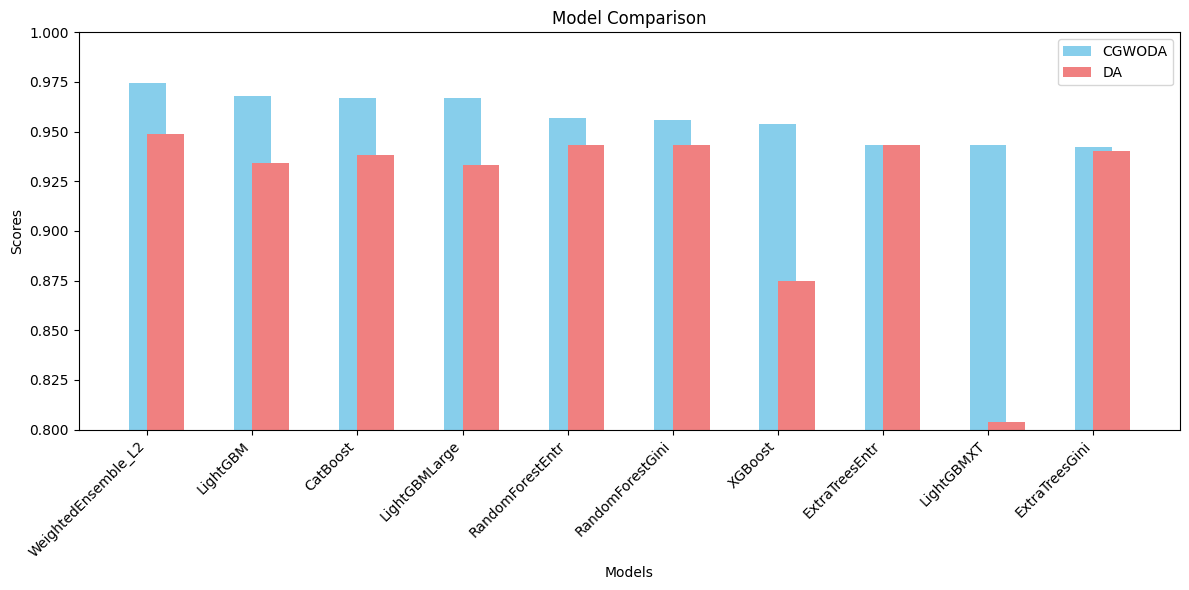

In [ ]:


df = davrscgwda

# Set the figure size
plt.figure(figsize=(12, 6))

# Get model names and algorithm scores
models = df['Models']
scores_cgwoda = df['CGWODA']
scores_da = df['DA']

# Define the width of the bars
bar_width = 0.35
ind = range(len(models))

# Plot the scores for CGWODA and DA
plt.bar(ind, scores_cgwoda, bar_width, label='CGWODA', color='skyblue', align='center')
plt.bar(ind, scores_da, bar_width, label='DA', color='lightcoral', align='edge')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(ind, models, rotation=45, ha='right')
plt.ylim(0.8,1)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
dataset_names = []

for dataset_number in range(1, 7):
    cgwoda = f"cgwoda{dataset_number}"
    da=f"da_{dataset_number}"
    pso=f"pso{dataset_number}"
    go=f"go{dataset_number}"
    grey=f"grey{dataset_number}"

    dataset_names.append(cgwoda)
    dataset_names.append(da)
    dataset_names.append(grey)
    dataset_names.append(go)

In [ ]:
dataset_names

['cgwoda1',
 'da_1',
 'grey1',
 'go1',
 'cgwoda2',
 'da_2',
 'grey2',
 'go2',
 'cgwoda3',
 'da_3',
 'grey3',
 'go3',
 'cgwoda4',
 'da_4',
 'grey4',
 'go4',
 'cgwoda5',
 'da_5',
 'grey5',
 'go5',
 'cgwoda6',
 'da_6',
 'grey6',
 'go6']

In [ ]:
import pandas as pd
method_names=['cgowda','da','pso','go','grey']
# Create an empty DataFrame with columns as method names
df = pd.DataFrame(columns=method_names)

# Example function to retrieve 'score_val' based on the method and dataset number
def get_score_val(method, dataset_number):
    # Replace this with your actual data retrieval method
    # Assuming you have a DataFrame for each method and dataset
    variable_name = f"{method}{dataset_number}"

    # Check if the variable exists, and if it's a DataFrame with a 'score_val' column
    if variable_name in locals() and isinstance(locals()[variable_name], pd.DataFrame) and 'score_val' in locals()[variable_name].columns:
        return locals()[variable_name]['score_val'].values[0]
    else:
        return None  # Return None if the variable or 'score_val' doesn't exist

# Add rows with dataset numbers
for dataset_number in dataset_numbers:
    row_data = {method: get_score_val(method, dataset_number) for method in method_names}
    df = df.append(row_data, ignore_index=True)

# Now, df contains the 'score_val' values from your DataFrames for the specified method and dataset number


<ipython-input-83-0093e62f93d5>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
<ipython-input-83-0093e62f93d5>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
<ipython-input-83-0093e62f93d5>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
<ipython-input-83-0093e62f93d5>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row_data, ignore_index=True)
<ipython-input-83-0093e62f93d5>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

In [ ]:
accuracy_table =pd.DataFrame

In [ ]:
column_names=['Dataset Name','CGWODA','DA','GO','GWO']

In [ ]:
accuracy_table.columns=column_names

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_algorithm_comparison(df, title='Algorithm Performance Comparison'):
    # Set the figure size
    plt.figure(figsize=(20, 5))

    # Get dataset names and algorithm scores
    dataset_names = df.columns[1:]  # Exclude the first column (assumed to be the algorithm names)
    algorithm_names = df.iloc[:, 0]  # Assume the first column contains algorithm names

    # Define the width of the bars
    bar_width = 0.1

    # Create an array of indices for x-axis positions
    ind = np.arange(len(dataset_names))

    # Plot the scores for each algorithm
    for i, algorithm in enumerate(algorithm_names):
        algorithm_scores = df.iloc[i, 1:]  # Scores for the current algorithm
        plt.bar(ind + i * bar_width, algorithm_scores, bar_width, label=algorithm)

    # Add labels and title
    plt.xlabel('Datasets')
    plt.ylabel('Scores')
    plt.title(title)
    plt.xticks(ind + (len(algorithm_names) - 1) * bar_width / 2, dataset_names, rotation=45, ha='right')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

# Create an empty DataFrame to store the first row's score_val for each algorithm and dataset
first_row_scores_df = pd.DataFrame(columns=['Algorithm', 'Dataset', 'score_val'])

# Extract the first row's score_val for each algorithm and dataset
algorithms = ['cgowda', 'da', 'go', 'pso', 'grey']  # Assuming your DataFrame names are in lowercase
dataset_numbers = range(1, 7)  # Assuming dataset numbers range from 1 to 6

for dataset_number in dataset_numbers:
    for algorithm in algorithms:
        df_name = f'{algorithm}{dataset_number}'  # Construct the DataFrame name
        if df_name in locals():
            df_algorithm = locals()[df_name]  # Get the corresponding DataFrame
            first_row_score_val = df_algorithm.iloc[0]['score_val'] if len(df_algorithm) > 0 else None  # Extract the first row's score_val
            first_row_scores_df = first_row_scores_df.append({'Algorithm': algorithm.upper(), 'Dataset': dataset_number, 'score_val': first_row_score_val}, ignore_index=True)

# Pivot the DataFrame to have dataset numbers as the first column and algorithm names as the row index
pivot_df = first_row_scores_df.pivot(index='Dataset', columns='Algorithm', values='score_val')

# Now, pivot_df contains the desired format



# RESULTS

In [18]:
pivot_df

Algorithm,CGOWDA,DA,GO,GREY,PSO
Dataset,,,,,
1,0.974306,0.948613,0.976362,0.969168,0.942446
2,0.959873,0.921859,0.965153,0.952482,0.950370
3,0.985600,0.964800,0.986800,0.985600,0.962000
4,1.000000,0.865600,0.999200,1.000000,1.000000
5,0.892308,0.892308,0.876923,0.892308,0.892308
6,0.952482,0.946146,0.960929,0.952482,0.951426


In [ ]:
pivot_df=pivot_df.drop('GO',axis=1)

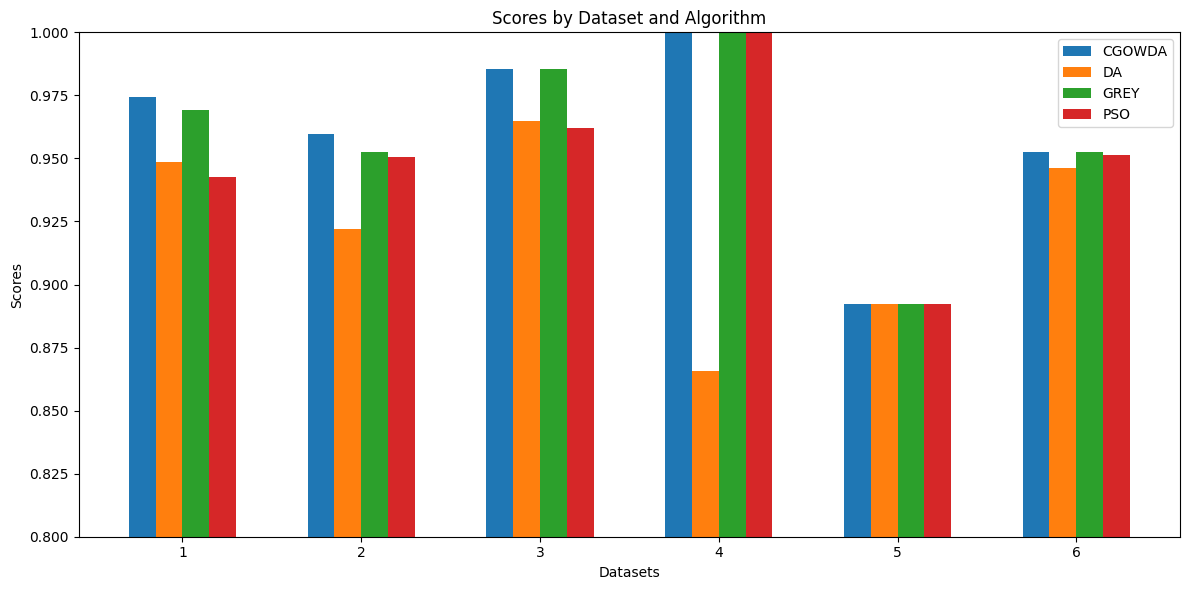

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming you have your data in pivot_df
# data = {
#     'Dataset': [1, 2, 3, 4, 5, 6],
#     'CGOWDA': [0.974306269270298, 0.9598732840549102, 0.9856, 1.0, 0.8923076923076924, 0.9524815205913412],
#     'DA': [0.948612538540596, 0.9218585005279832, 0.9648, 0.8656, 0.8923076923076924, 0.9461457233368532],
#     'GO': [0.9763617677286742, 0.9651531151003168, 0.9868, 0.9992, 0.8769230769230769, 0.9609292502639916],
#     'GREY': [0.9691675231243576, 0.9524815205913412, 0.9856, 1.0, 0.8923076923076924, 0.9524815205913412],
#     'PSO': [0.9424460431654677, 0.9503695881731784, 0.962, 1.0, 0.8923076923076924, 0.9514255543822596]
# }

# df = pd.DataFrame(data)
pivot_df
# Set the figure size
plt.figure(figsize=(12, 6))

# Get dataset names and algorithm scores
dataset_names = pivot_df.index
algorithm_names = pivot_df.columns  # Exclude the first column (assumed to be the dataset names)

# Define the width of the bars and the number of datasets
bar_width = 0.15
num_datasets = len(dataset_names)

# Create an array of indices for x-axis positions
ind = list(range(num_datasets))

# Plot the scores for each algorithm
for i, algorithm in enumerate(algorithm_names):
    algorithm_scores = df[algorithm]
    plt.bar([x + i * bar_width for x in ind], algorithm_scores, bar_width, label=algorithm)

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Scores')
plt.title('Scores by Dataset and Algorithm')

# Set x-axis ticks and labels
plt.xticks([x + (len(algorithm_names) - 1) * bar_width / 2 for x in ind], dataset_names)
plt.ylim(0.8, 1.0)  # Adjust the limits as needed
# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


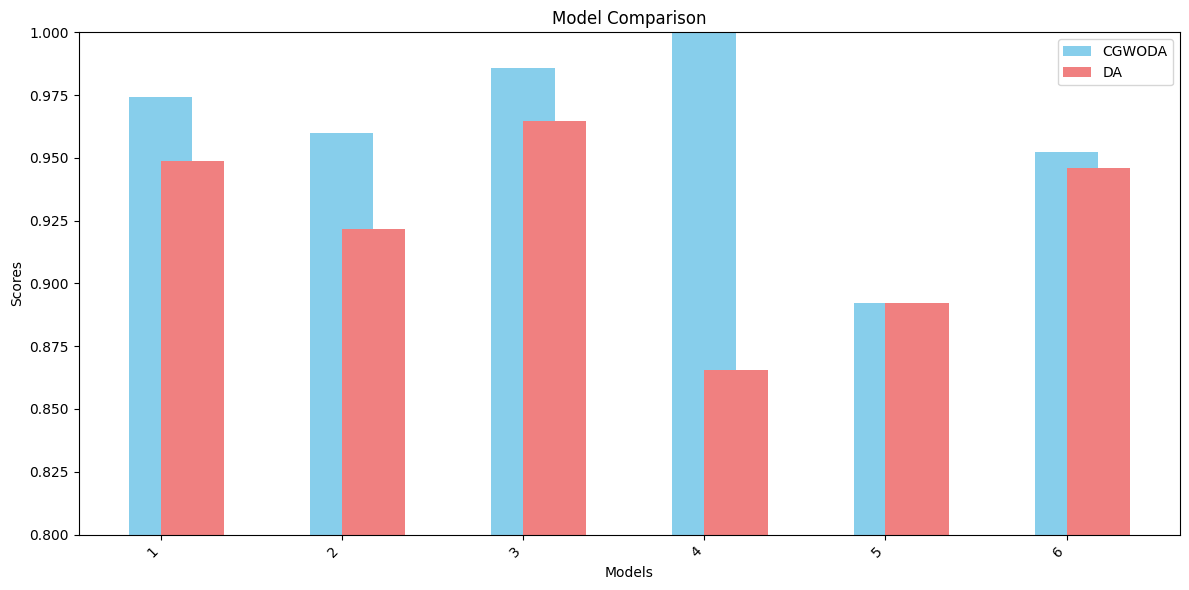

In [23]:
df = davrscgwda

# Set the figure size
plt.figure(figsize=(12, 6))

# Get model names and algorithm scores
models = pivot_df.index
scores_cgwoda = pivot_df['CGOWDA']
scores_da =pivot_df['DA']

# Define the width of the bars
bar_width = 0.35
ind = range(len(models))

# Plot the scores for CGWODA and DA
plt.bar(ind, scores_cgwoda, bar_width, label='CGWODA', color='skyblue', align='center')
plt.bar(ind, scores_da, bar_width, label='DA', color='lightcoral', align='edge')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.xticks(ind, models, rotation=45, ha='right')
plt.ylim(0.8,1)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()